In [32]:
import warnings
import graphviz
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
# Import ML Classification algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
data = pd.read_csv("./Data/iris.CSV",engine="python")
data

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
SEPAL_LENGTH    150 non-null float64
SEPAL_WIDTH     150 non-null float64
PETAL_LENGTH    150 non-null float64
PETAL_WIDTH     150 non-null float64
SPECIES         150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


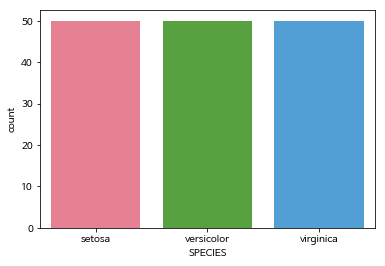

In [33]:
# 결측치 없다.
data.isnull().sum(axis=0)
#데이터 타입 확인
data.info()
# Checking if classes are unbalanced or balanced
data['SPECIES'].value_counts()
# '1' 은 Malignant으로 악성이다 -> 212/(212 + 357) = 0.37 
# '0' 은 Benign으로 양성이다 -> 357/(212+357) = 0.627
sns.countplot(data.SPECIES)
sns.countplot(data['SPECIES'],  palette = "husl")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017EB416A4E0>,
      dtype=object)

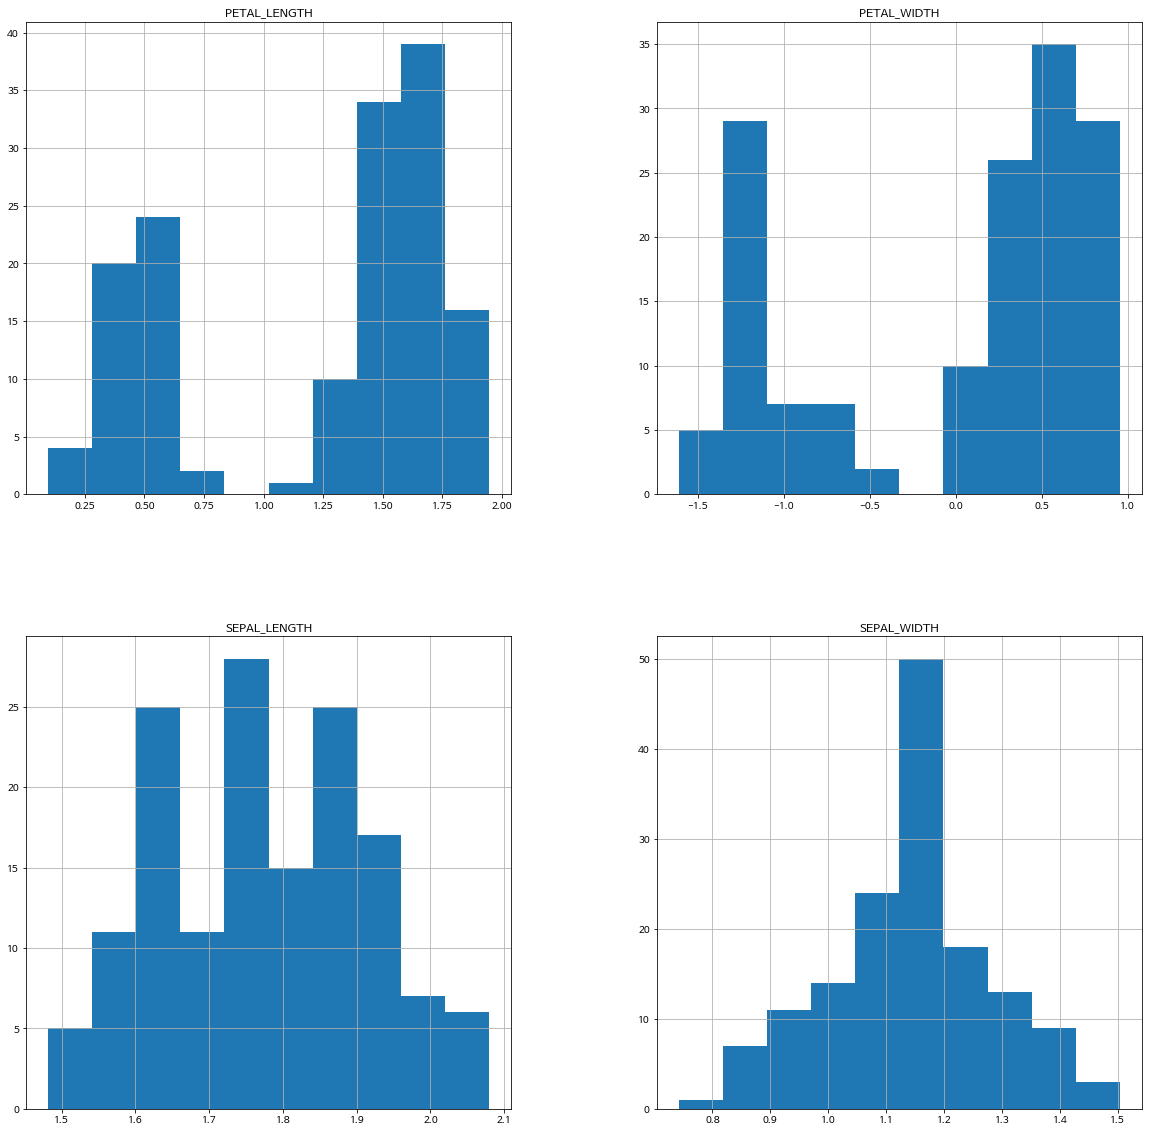

In [34]:
data_x = data.drop("SPECIES",axis=1)
data_y = data["SPECIES"]

X_log = data_x.apply(lambda x: np.log(x + 0.1))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_log)
X_log.hist(figsize = (20,20))

In [35]:
# 데이터 분할(train, test 데이터 7:3으로 - numpy->random)
np.random.seed(seed=1234)

# 0.7보다 작으면 True -> train 데이터, 아니면 False -> test 데이터
msk = np.random.rand(data.shape[0]) < 0.7
data_train = data[msk]
data_test = data[~msk]

# train/test 데이터의 목표변수/설명변수 지정
data_train_y = data_train["SPECIES"]
data_train_x = data_train.drop("SPECIES", axis=1, inplace=False)
data_test_y = data_test["SPECIES"]
data_test_x = data_test.drop("SPECIES", axis=1, inplace=False)

# train데이터와 test데이터 크기
print("train data X size: {}".format(data_train_x.shape))
print("train data Y size: {}".format(data_train_y.shape))
print("test data X size: {}".format(data_test_x.shape))
print("test data Y size: {}".format(data_test_y.shape))

# train data: 385, test data: 184

train data X size: (103, 4)
train data Y size: (103,)
test data X size: (47, 4)
test data Y size: (47,)


In [36]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(data_train_x, data_train_y)

# 훈련 데이터 정확도
print("Accuracy on training set:{:.3f}".format(tree_uncustomized.score(data_train_x,
                                                                      data_train_y)))
print("Accuracy on training set:{:3f}".format(tree_uncustomized.score(data_test_x,
                                                                      data_test_y)))


Accuracy on training set:1.000
Accuracy on training set:0.936170


In [37]:
tree_uncustomized.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')>

# para_criterion = ["gini", "entropy"]

tree3 = DecisionTreeClassifier(criterion='entropy',min_samples_split=10,
                                      min_samples_leaf=5, random_state=1234)
tree3.fit(data_train_x, data_train_y)
print((tree3.score(data_train_x, data_train_y)))
print((tree3.score(data_test_x, data_test_y)))

In [50]:
para_criterion = ["gini", "entropy"]

tree3 = DecisionTreeClassifier(criterion='gini',min_samples_split=10,
                                      min_samples_leaf=5, random_state=1234)
tree3.fit(data_train_x, data_train_y)
print((tree3.score(data_train_x, data_train_y)))
print((tree3.score(data_test_x, data_test_y)))

0.970873786407767
0.9787234042553191
